In [20]:

 !pip -q install --upgrade "transformers>=4.37,<5" "datasets>=2.10" "evaluate>=0.4.1" "accelerate>=0.19" scikit-learn matplotlib


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import torch
print("Torch version:", torch.__version__)

Torch version: 2.6.0+cu124


In [22]:
# ===== USER CONFIG - change these if you want =====
MODEL_NAME = "roberta-base"     # change to 'bert-base-uncased' etc. if preferred
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
TEST_SIZE = 0.15
RANDOM_STATE = 42

OUTPUT_DIR = Path("./outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


In [23]:
from datasets import load_dataset

# 1) Try to load a Kaggle-attached CSV automatically (if present)
kaggle_csv = None
kaggle_input_dir = Path("/kaggle/input")
if kaggle_input_dir.exists():
    csvs = list(kaggle_input_dir.glob("**/*.csv"))
    if csvs:
        # pick largest CSV as heuristic
        kaggle_csv = sorted(csvs, key=lambda p: p.stat().st_size, reverse=True)[0]

if kaggle_csv:
    print("Found Kaggle CSV, using:", kaggle_csv)
    df = pd.read_csv(kaggle_csv)
    # Try to identify basic text/label columns
    # Heuristics:
    text_col = next((c for c in df.columns if c.lower() in ["text","post","content","body","sentence","comment","selftext","tweet"]), df.columns[0])
    label_col = next((c for c in df.columns if c.lower() in ["label","target","class","category","label_id","sentiment","emotion","subreddit"]), None)
    if label_col is None:
        # choose a low-cardinality column as label
        for c in df.columns:
            if df[c].nunique() <= 20:
                label_col = c
                break
    print("Guessed text_col:", text_col, "label_col:", label_col)
    df = df[[text_col, label_col]].dropna().rename(columns={text_col:"text", label_col:"label"})
    dataset = load_dataset('pandas', data_files={'train': df})
    # dataset will be a DatasetDict with single split; later we'll split into train/val
else:
    # 2) Otherwise, load an online dataset from Hugging Face (demo)
    print("No Kaggle CSV found — loading Hugging Face 'emotion' demo dataset")
    dataset = load_dataset("emotion")  # 'train', 'validation', 'test' splits included
    # Rename columns to consistent names
    # emotion has 'text' and 'label' already (label is numeric)
    # We'll map numeric labels to human names for readability
    label_list = dataset["train"].features["label"].names
    print("Emotion labels:", label_list)


No Kaggle CSV found — loading Hugging Face 'emotion' demo dataset
Emotion labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


Number of train rows: 16000
{'text': 'i didnt feel humiliated', 'label': 0}
Label counts (index are label ids):
 label
0    4666
1    5362
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64


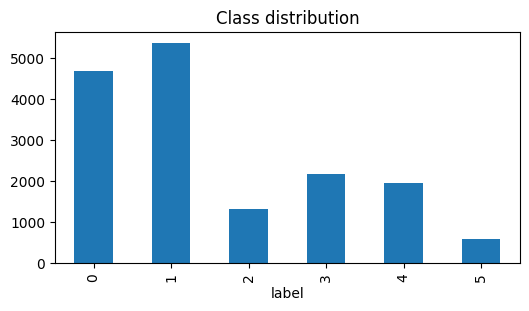

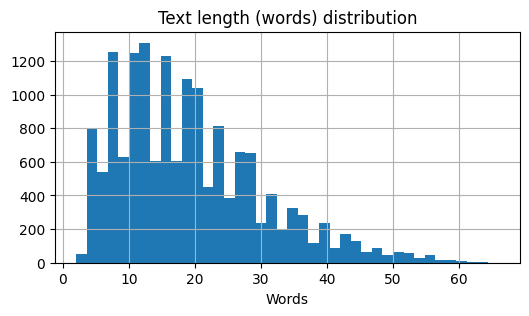

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4


In [24]:
# Quick preview & EDA
if "train" in dataset:
    ds_train = dataset["train"]
else:
    ds_train = dataset["train"]

print("Number of train rows:", len(ds_train))
print(ds_train[0])

# Convert to pandas for EDA convenience
df_train = ds_train.to_pandas()
if "validation" in dataset:
    df_val = dataset["validation"].to_pandas()
else:
    # later we'll create a split if only 'train' exists
    df_val = pd.DataFrame()

# Basic class counts
if "label" in df_train.columns:
    counts = df_train["label"].value_counts().sort_index()
    print("Label counts (index are label ids):\n", counts)
    plt.figure(figsize=(6,3))
    counts.plot(kind="bar")
    plt.title("Class distribution")
    plt.show()

# Text length distribution (words)
text_lengths = df_train["text"].astype(str).str.split().apply(len)
plt.figure(figsize=(6,3))
text_lengths.hist(bins=40)
plt.title("Text length (words) distribution")
plt.xlabel("Words")
plt.show()

df_train.head(8)


In [25]:
from sklearn.model_selection import train_test_split

# If dataset already has validation split (like 'emotion'), use it;
# otherwise split 'train' into train/validation.
if "validation" in dataset:
    hf_datasets = dataset
else:
    print("Creating train/validation split from single 'train' split")
    df_all = df_train.reset_index(drop=True)
    train_df, val_df = train_test_split(df_all, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df_all["label"] if "label" in df_all.columns else None)
    from datasets import Dataset, DatasetDict
    hf_datasets = DatasetDict({
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "validation": Dataset.from_pandas(val_df.reset_index(drop=True))
    })
    print("Train / Validation sizes:", len(hf_datasets["train"]), len(hf_datasets["validation"]))


In [26]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def preprocess_fn(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

# map tokenization onto the datasets
tokenized_datasets = hf_datasets.map(preprocess_fn, batched=True, remove_columns=[c for c in hf_datasets["train"].column_names if c!="text" and c!="label"])
# Ensure label column exists and is named "labels" for Trainer
tokenized_datasets = tokenized_datasets.rename_column("label", "labels") if "label" in tokenized_datasets["train"].column_names else tokenized_datasets
# Keep only torch tensors columns
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_datasets


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [27]:
import evaluate
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# --- Detect correct label column dynamically ---
possible_label_cols = ["labels", "label", "target", "sentiment"]
label_col = None
for col in possible_label_cols:
    if col in hf_datasets["train"].features:
        label_col = col
        break

if label_col is None:
    raise ValueError(
        f"Could not find any of {possible_label_cols} in dataset columns: {hf_datasets['train'].features.keys()}"
    )

print(f"✅ Using '{label_col}' as the label column")

# Only rename if needed
if label_col != "labels":
    hf_datasets = hf_datasets.rename_column(label_col, "labels")

# --- Determine num_labels and label mapping ---
feature = hf_datasets["train"].features["labels"]
if hasattr(feature, "names"):  # if it's a ClassLabel
    label_list = feature.names
else:
    label_list = sorted(set(hf_datasets["train"]["labels"]))

num_labels = len(label_list)
print("num_labels:", num_labels, "labels:", label_list)

# --- Load model ---
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

# --- Metrics ---
metric_acc = evaluate.load("accuracy")
metric_f1  = evaluate.load("f1")
metric_pr  = evaluate.load("precision")
metric_rc  = evaluate.load("recall")

def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "precision": metric_pr.compute(predictions=preds, references=labels, average="weighted")["precision"],
        "recall": metric_rc.compute(predictions=preds, references=labels, average="weighted")["recall"],
        "f1": metric_f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
    }

training_args = TrainingArguments(
    output_dir=str(OUTPUT_DIR),
    do_eval=True,
    eval_steps=500,
    save_steps=500,
    logging_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir='./logs'
)


✅ Using 'label' as the label column
num_labels: 6 labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Start training
train_result = trainer.train()
trainer.save_model()  # save best model + tokenizer below separately


/tmp/ipykernel_36/2593506636.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


<IPython.core.display.Javascript object>

In [ ]:
# Predict on validation
pred_out = trainer.predict(tokenized_datasets["validation"])
y_true = pred_out.label_ids
y_prob = pred_out.predictions
y_pred = np.argmax(y_prob, axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("Classification report:")
if isinstance(label_list[0], str):
    target_names = label_list
else:
    # numeric labels -> use stringified labels
    target_names = [str(l) for l in label_list]
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(target_names)), labels=target_names, rotation=45)
plt.yticks(ticks=np.arange(len(target_names)), labels=target_names)
plt.show()

# If binary, compute ROC-AUC
if num_labels == 2:
    from sklearn.metrics import roc_auc_score, RocCurveDisplay
    try:
        y_scores = torch.softmax(torch.tensor(y_prob), dim=1).numpy()[:,1]
        auc = roc_auc_score(y_true, y_scores)
        print(f"ROC-AUC: {auc:.4f}")
        RocCurveDisplay.from_predictions(y_true, y_scores)
        plt.show()
    except Exception as e:
        print("Could not compute ROC-AUC:", e)


In [ ]:
# Load validation into pandas to inspect texts
val_pd = tokenized_datasets["validation"].to_pandas()
val_pd = val_pd.reset_index(drop=True)
val_pd["pred"] = y_pred
val_pd["true"] = y_true
# If dataset has mapping of label ids to names, map for readability
try:
    label_names = label_list
    val_pd["pred_label"] = val_pd["pred"].map(lambda x: label_names[x])
    val_pd["true_label"] = val_pd["true"].map(lambda x: label_names[x])
except:
    val_pd["pred_label"] = val_pd["pred"].astype(str)
    val_pd["true_label"] = val_pd["true"].astype(str)

mistakes = val_pd[val_pd["pred"] != val_pd["true"]]
print(f"Misclassified: {len(mistakes)} of {len(val_pd)}")
# show top 20 mistakes with text snippet
display_cols = [c for c in val_pd.columns if c in ["text","true_label","pred_label","pred","true"]]
if display_cols:
    display(mistakes[display_cols].head(20))
else:
    print(mistakes.head(10))


In [ ]:
SAVE_DIR = Path("./mental_health_model")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

trainer.save_model(SAVE_DIR.as_posix())
tokenizer.save_pretrained(SAVE_DIR.as_posix())

# Save label list / mapping if available
with open(SAVE_DIR / "label_list.json", "w") as f:
    json.dump({"label_list": label_list}, f)

print("Saved model & tokenizer to", SAVE_DIR.resolve())


In [ ]:
# Load back model+tokenizer (optional)
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tok = AutoTokenizer.from_pretrained(SAVE_DIR.as_posix())
mdl = AutoModelForSequenceClassification.from_pretrained(SAVE_DIR.as_posix())
mdl.eval()

def predict_texts(texts, top_k=1):
    enc = tok(texts, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
    with torch.no_grad():
        out = mdl(**enc)
        probs = torch.softmax(out.logits, dim=1).cpu().numpy()
    preds = probs.argmax(axis=1)
    return [{"text":t, "pred_id":int(p), "pred_label": label_list[int(p)] if isinstance(label_list[0], str) else str(int(p)), "probs":list(map(float,arr))} for t,p,arr in zip(texts,preds,probs)]

# Quick test
samples = [
    "I feel really down and hopeless today.",
    "I am so excited about my new job!",
    "I'm worried about how I'm going to cope with everything."
]
preds = predict_texts(samples)
for p in preds:
    print(p)
